In [9]:
#Necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from math import sqrt
import datetime 
import calendar
import sys
from statsmodels.tsa.vector_ar.vecm import VECM

In [10]:
# Load your data
file_path = r'C:\Users\PHIRI003\OneDrive - Wageningen University & Research\Documents\WEcR Internship\Work\R\Modified_Book1.xlsx'
data = pd.read_excel(file_path, header=0 )

# Ensure the data has a datetime index
#date_range = pd.date_range(start='2010-01-01', periods=len(df), freq='M')
#df.index = date_range

data['Date'] = pd.to_datetime(data['Date'])

# Define the start and end dates
start_date = '2010-01-01'
end_date = '2023-10-31'

# Filter the DataFrame to include only the desired date range
df = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Display the first few rows of the filtered data
print(df.head())



    MonthCode       Date        PPI       Wheat    WheatPI        CPI  \
60     201001 2010-01-01  87.017267  167.821863  90.463580  86.922856   
61     201002 2010-02-01  86.930596  160.161560  86.334330  86.961094   
62     201003 2010-03-01  86.930596  156.464118  84.341241  86.616958   
63     201004 2010-04-01  86.323902  156.825469  84.536026  86.817704   
64     201005 2010-05-01  86.323902  158.328460  85.346206  86.875060   

         OilPI    Oil       Wage  
60  182.403065  76.17  82.204205  
61  176.607930  73.75  82.204205  
62  188.772924  78.83  82.286657  
63  203.117080  84.82  82.286657  
64  181.876235  75.95  82.369108  


In [4]:
#lag length selection
from statsmodels.tsa.api import VAR
selected_data = df[['PPI', 'CPI']]

#model fitting 
model = VAR(selected_data)

#optimal lag length 
lag_order = model.select_order(maxlags=12)  

print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        6.040       6.071       419.9       6.053
1       -1.128      -1.035      0.3235      -1.091
2       -1.381     -1.224*      0.2514      -1.317
3       -1.423      -1.204      0.2410     -1.335*
4       -1.431      -1.150      0.2391      -1.317
5       -1.424      -1.080      0.2409      -1.285
6       -1.447      -1.041      0.2353      -1.283
7       -1.495      -1.026      0.2244      -1.306
8      -1.512*     -0.9809     0.2206*      -1.298
9       -1.486     -0.8921      0.2265      -1.246
10      -1.470     -0.8139      0.2302      -1.205
11      -1.447     -0.7282      0.2356      -1.157
12      -1.457     -0.6760      0.2334      -1.142
--------------------------------------------------


In [5]:
# Extract the endogenous variables
endog = model.endog

# Calculate the correlation matrix
corr_matrix = np.corrcoef(endog, rowvar=False)
print(corr_matrix)

[[1.         0.98365101]
 [0.98365101 1.        ]]


In [11]:
# Define the function to create seasonal dummy variables
def SeasonalDummies(df, frequency='M'):
    nT = len(df)  # Number of observations
    startdate = df.index[0]  # Start date of the time series
    datetime = pd.DataFrame(data=pd.date_range(startdate, periods=nT, freq=frequency), columns=["datetime"])
    monthnumber = datetime["datetime"].dt.month  # Extract month numbers
    monthname = pd.DataFrame()  # DataFrame to store month names
    
    for i in range(nT):
        monthname.at[i, 'D'] = calendar.month_name[monthnumber[i]]  # Assign month names based on month numbers
    
    seasdum = pd.get_dummies(monthname['D'], prefix='D')  # Create dummy variables for each month
    seasdum = seasdum.drop('D_January', axis=1)  # Drop January to avoid multicollinearity
    seasdum = seasdum.set_index(df.index)  # Set the index to match the original DataFrame
    seasdum = seasdum.astype(int)
    return seasdum

# Create seasonal dummies
seasdum = SeasonalDummies(df)

#merge data with seasonal dummies
df_with_dummies = pd.concat([df, seasdum], axis=1) 

In [13]:
#GREGORY AND HANSEN TEST FOR COINTEGRATION
from statsmodels.tsa.stattools import adfuller

#Create a break dummy
break_date = '2022-02-28'
df_with_dummies['break_dummy'] = (df_with_dummies['Date'] >= break_date).astype(int)

#Create interaction term
df_with_dummies['interaction_term'] = df_with_dummies['break_dummy']*df_with_dummies['PPI']

#create a trend
df_with_dummies['trend'] = range(1, len(df_with_dummies) + 1)  # Trend variable from 1 to number of observations

#print(df_with_dummies.head())

#Cointegration regression variables
X = df_with_dummies[['trend','CPI', 'break_dummy', 'interaction_term','D_April', 'D_August', 'D_December', 'D_February',  'D_July',  'D_June',  'D_March', 'D_May', 'D_September', 'D_October', 'D_November']]
X = sm.add_constant(X)  # Adds a constant term 
Y = df_with_dummies['PPI']

coint_reg_result = sm.OLS(Y, X).fit()

# Extract and store residuals in the DataFrame
df_with_dummies['residuals'] = coint_reg_result.resid

# Ensure residuals are in the correct format for the ADF test
residuals = df_with_dummies['residuals'].astype(float)

# Perform the ADF test on the residuals
adf_test = adfuller(residuals, maxlag=12, regression='c')

print(coint_reg_result.summary())
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

                            OLS Regression Results                            
Dep. Variable:                    PPI   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1263.
Date:                Mon, 26 Aug 2024   Prob (F-statistic):          1.48e-149
Time:                        15:17:46   Log-Likelihood:                -196.29
No. Observations:                 166   AIC:                             424.6
Df Residuals:                     150   BIC:                             474.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               74.8023      3.439  

In [6]:
#Create a break dummy
break_date2 = '2021-09-30'
df_with_dummies['break_dummy2'] = (df_with_dummies['Date'] >= break_date2).astype(int)

#Create differenced vars
columns = ['PPI','CPI','WheatPI','OilPI', 'Wage', 'break_dummy2' ]

for column in columns:
    df_with_dummies[f'diff_{column}'] = df_with_dummies[column].diff()

#print(df_with_dummies.head(5))

In [7]:
import re
df_with_dummies.dropna(inplace=True)

X2 = df_with_dummies[['diff_WheatPI', 'diff_OilPI', 'diff_Wage', 'break_dummy2', 'D_April', 'D_August', 'D_December', 'D_February',  'D_July',  'D_June',  'D_March', 'D_May', 'D_September', 'D_October', 'D_November']]

Y2 = df_with_dummies[['PPI', 'CPI']]

exog_names = ['diff_WheatPI', 'diff_OilPI', 'diff_Wage', 'break_dummy2', 
             'D_April', 'D_August', 'D_December', 
              'D_February', 'D_July', 'D_June', 'D_March', 'D_May', 'D_September', 
              'D_October', 'D_November']

def rename_exog_variables(summary_text, exog_names):
    # Creating a mapping from 'exogX' to actual variable names
    exog_map = {f'exog{i+1}': name for i, name in enumerate(exog_names)}

    # Replacing the exogX in the summary text with the actual names
    for exog, name in exog_map.items():
        summary_text = re.sub(r'\b{}\b'.format(exog), name, summary_text)
    
    return summary_text

# Fit the VECM model
vecm = VECM(endog=Y2, exog=X2, k_ar_diff=8, coint_rank=1)  
vecm_fit= vecm.fit()

# Getting the summary as a string
summary_str = vecm_fit.summary().as_text()

# Rename exog variables
renamed_summary = rename_exog_variables(summary_str, exog_names)

# Print the mod summary
print(renamed_summary)


Det. terms outside the coint. relation & lagged endog. parameters for equation PPI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
diff_WheatPI         -0.0068      0.005     -1.274      0.203      -0.017       0.004
diff_OilPI         -0.0002      0.003     -0.061      0.952      -0.006       0.006
diff_Wage          0.2120      0.158      1.341      0.180      -0.098       0.522
break_dummy2          0.7117      0.213      3.338      0.001       0.294       1.129
D_April         -1.2251      0.254     -4.831      0.000      -1.722      -0.728
D_August         -1.4153      0.275     -5.146      0.000      -1.954      -0.876
D_December         -1.2056      0.239     -5.035      0.000      -1.675      -0.736
D_February         -1.3325      0.269     -4.950      0.000      -1.860      -0.805
D_July         -0.6688      0.246     -2.718      0.007      -1.151      -0.187
D_June   

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Length of Y2: 155
Length of fittedvalues: 155


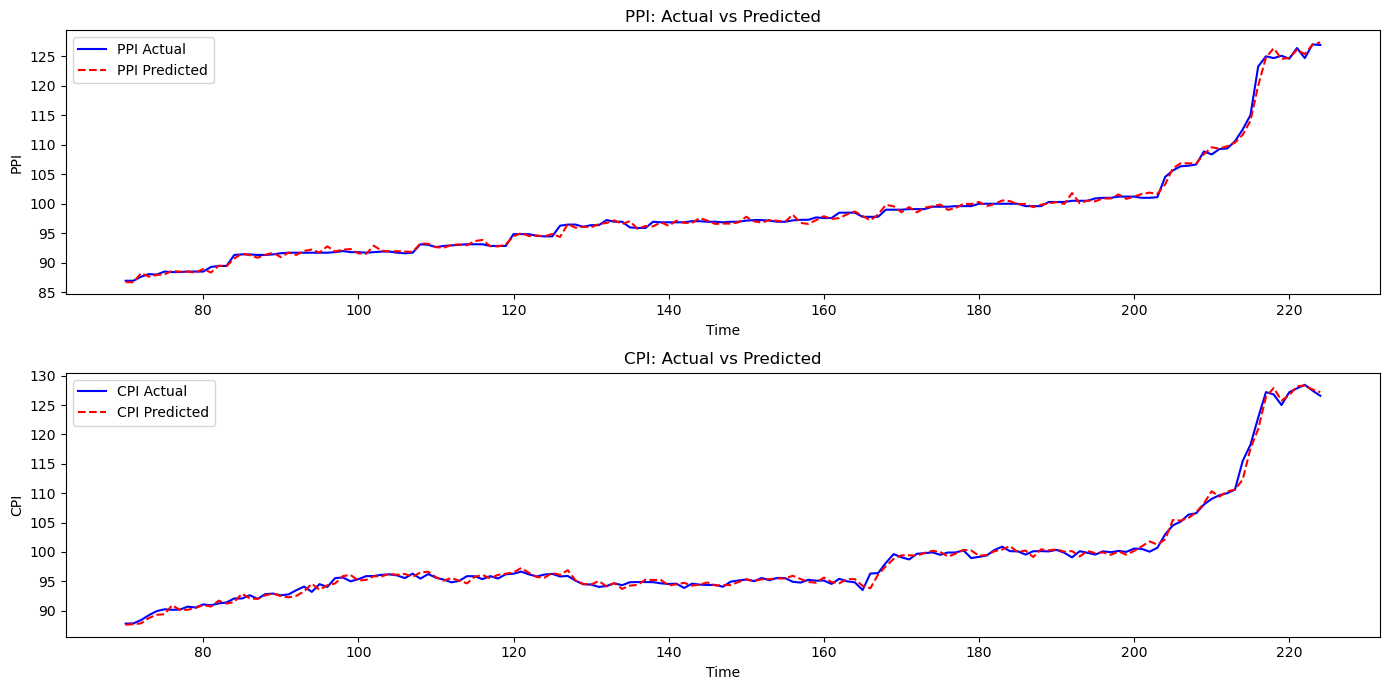

In [34]:
# Getting and plotting the predicted values
# removing the first 3 observations lost in lags and differencing
adjusted_Y2 = Y2.iloc[9:] 

# Check the lengths of Y2 and fitted values
print(f"Length of Y2: {len(adjusted_Y2)}")
print(f"Length of fittedvalues: {len(vecm_fit.fittedvalues)}")

#predicted_df = vecm_fit1.fittedvalues
predicted_df = pd.DataFrame(vecm_fit.fittedvalues, columns=adjusted_Y2 .columns)
predicted_df.index = adjusted_Y2.index # Ensure the index matches the actual data

# Combine actual and predicted values
comparison_df = pd.concat([adjusted_Y2, predicted_df], axis=1)
comparison_df.columns = ['PPI_Actual', 'CPI_Actual', 'PPI_Predicted', 'CPI_Predicted']

import matplotlib.pyplot as plt

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot for PPI
plt.subplot(2, 1, 1)
plt.plot(comparison_df.index, comparison_df['PPI_Actual'], label='PPI Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['PPI_Predicted'], label='PPI Predicted', color='red', linestyle='--')
plt.title('PPI: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('PPI')
plt.legend()

# Plot for CPI
plt.subplot(2, 1, 2)
plt.plot(comparison_df.index, comparison_df['CPI_Actual'], label='CPI Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['CPI_Predicted'], label='CPI Predicted', color='red', linestyle='--')
plt.title('CPI: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.legend()

plt.savefig('Comparison.png')
plt.tight_layout()
plt.show()



In [59]:
# Fit the VAR model
Y3 = df_with_dummies[['diff_CPI', 'diff_PPI']]
X3 = df_with_dummies[[ 'diff_WheatPI', 'diff_OilPI', 'diff_Wage','diff_break_dummy2','D_April', 'D_August', 'D_December', 'D_February',  'D_July',  'D_June',  'D_March', 'D_May', 'D_September', 'D_October', 'D_November']]

var = VAR(Y3, X3)  # defining the equation
var_fit = var.fit(8)
print(var_fit.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 22, Aug, 2024
Time:                     22:47:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                 -0.0564944
Nobs:                     156.000    HQIC:                 -0.799525
Log likelihood:          -276.707    FPE:                   0.273649
AIC:                     -1.30772    Det(Omega_mle):        0.188420
--------------------------------------------------------------------
Results for equation diff_CPI
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.009173         0.290984           -0.032           0.975
diff_WheatPI             -0.000257         0.007427           -0.035           0.972
diff_OilPI               -0.008785       

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [35]:
#Save the data in excel
df_with_dummies.to_excel(r'C:\Users\PHIRI003\OneDrive - Wageningen University & Research\Documents\WEcR Internship\Work\R\'Bread_data.xlsx')

In [36]:
from statsmodels.stats.diagnostic import het_arch
import pandas as pd

# Conduct the ARCH test for heteroscedasticity for each equation
arch_test_results = [het_arch(resid) for resid in vecm_fit.resid.T]

# Create a DataFrame to store the results
columns = ['Test Statistic', 'P-value', 'Lags used']
results_df = pd.DataFrame(columns=columns)

# Fill the DataFrame with the results
for i, result in enumerate(arch_test_results):
    test_statistic, p_value, lags_used, _ = result
    results_df.loc[f'Equation {i+1}'] = [test_statistic, p_value, lags_used]

# Display the results
print(results_df)

            Test Statistic   P-value  Lags used
Equation 1       13.668692  0.188647   1.394644
Equation 2        8.120573  0.617061   0.794975


In [37]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Loop through each residual series and apply the Ljung-Box test
for i in range(vecm_fit1.resid.shape[1]):
    print(f"Ljung-Box Test for Residuals of Equation {i+1}:")
    ljung_box_results = acorr_ljungbox(vecm_fit.resid[:, i], lags=[1, 5, 8])
    print(ljung_box_results)
    print("\n")



Ljung-Box Test for Residuals of Equation 1:
    lb_stat  lb_pvalue
1  0.130173   0.718253
5  2.188062   0.822559
8  4.475517   0.811878


Ljung-Box Test for Residuals of Equation 2:
    lb_stat  lb_pvalue
1  0.000229   0.987925
5  2.075061   0.838664
8  2.143046   0.976309




<Figure size 1000x500 with 0 Axes>

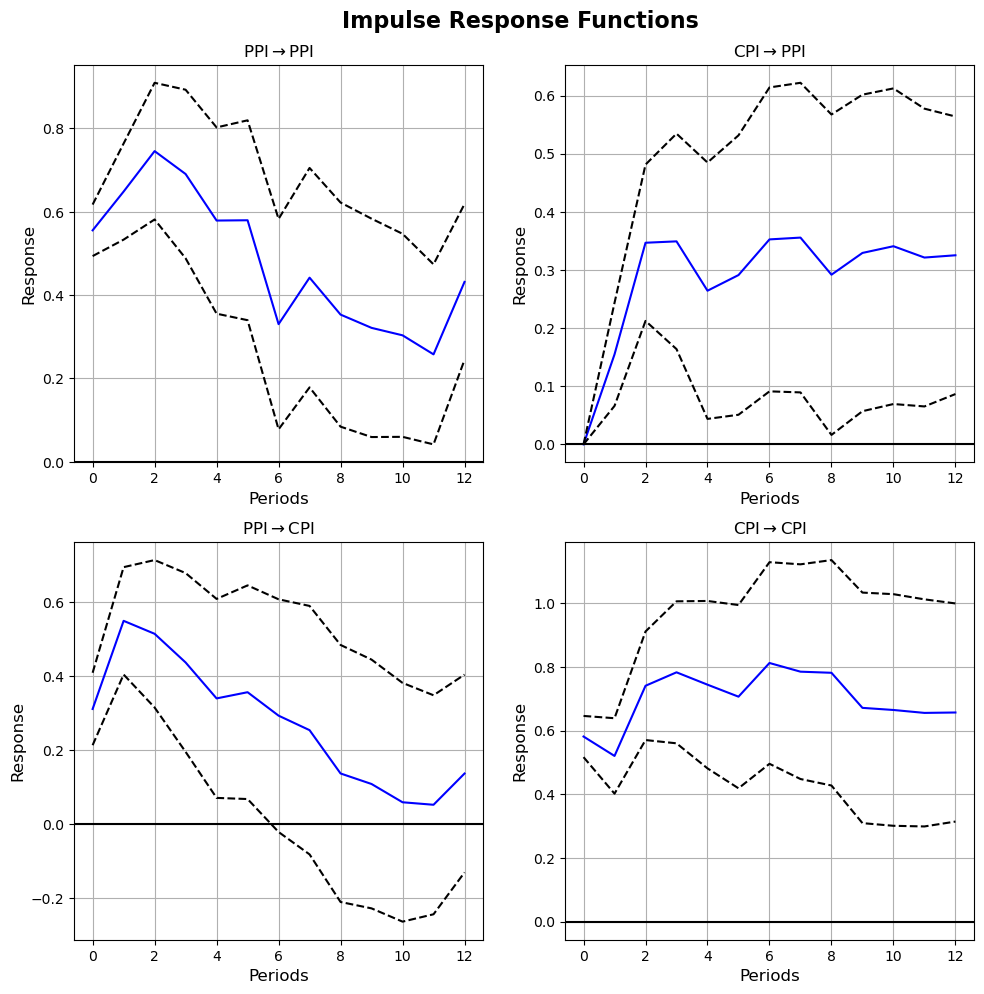

In [8]:
import matplotlib.pyplot as plt

# Generate impulse response functions
irf = vecm_fit.irf(periods=12)

# Plot the IRFs without confidence intervals
fig = plt.figure(figsize=(10, 5))  # Adjust the figure size (longer and narrower)
irf.plot(orth=True, plot_stderr=True)  # Confidence Intervals

# Customize the plot (title and labels)
plt.suptitle('Impulse Response Functions ', fontsize=16, fontweight='bold')

# Customize each subplot in the figure
for ax in plt.gcf().axes:
    ax.set_xlabel('Periods', fontsize=12)
    ax.set_ylabel('Response', fontsize=12)
    ax.grid(True)  # Add gridlines for better readability
    ax.xaxis.set_tick_params(labelbottom=True)  # Ensure x-axis labels are visible on all plots

# Save and show the plot
plt.savefig('irf_plot_no_ci_period_labels.png', bbox_inches='tight')  # Save the figure with tight layout
plt.show()


In [42]:
from statsmodels.tsa.api import VAR

var_model = VAR(vecm_fit.model.endog)
#var_fit = var_model.fit(maxlags=vecm_fit.k_ar_diff)

n_lags = vecm_fit.k_ar

var_fit = var_model.fit(maxlags=n_lags)

# Step 3: Perform variance decomposition
fevd = var_fit.fevd(periods=12)

# Step 4: Print the results
print(fevd.summary())


FEVD for y1
            y1        y2
0     1.000000  0.000000
1     0.948504  0.051496
2     0.840828  0.159172
3     0.794954  0.205046
4     0.769676  0.230324
5     0.753149  0.246851
6     0.722419  0.277581
7     0.701515  0.298485
8     0.682914  0.317086
9     0.660424  0.339576
10    0.643181  0.356819
11    0.629371  0.370629

FEVD for y2
            y1        y2
0     0.235287  0.764713
1     0.438784  0.561216
2     0.414113  0.585887
3     0.369011  0.630989
4     0.354094  0.645906
5     0.354391  0.645609
6     0.346214  0.653786
7     0.339299  0.660701
8     0.329928  0.670072
9     0.324024  0.675976
10    0.317661  0.682339
11    0.313662  0.686338


None


In [132]:
#Granger causality
# Granger Causality Test Function
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_test(df_with_dummies, var1, var2, max_lag):
    print(f'Granger Causality Test: {var1} causes {var2}')
    test_result = grangercausalitytests(df[[var2, var1]], max_lag, verbose=True)
    return test_result

# Usage
max_lag = 8

granger_causality_test(df_with_dummies, 'PPI', 'CPI', max_lag)
granger_causality_test(df_with_dummies, 'Wheat', 'CPI', max_lag)
granger_causality_test(df_with_dummies, 'Oil', 'CPI', max_lag)
granger_causality_test(df_with_dummies, 'CPI', 'PPI', max_lag)
granger_causality_test(df_with_dummies, 'Wheat', 'PPI', max_lag)
granger_causality_test(df_with_dummies, 'Oil', 'PPI', max_lag)


Granger Causality Test: PPI causes CPI

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2763  , p=0.2598  , df_denom=224, df_num=1
ssr based chi2 test:   chi2=1.2934  , p=0.2554  , df=1
likelihood ratio test: chi2=1.2897  , p=0.2561  , df=1
parameter F test:         F=1.2763  , p=0.2598  , df_denom=224, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=18.8997 , p=0.0000  , df_denom=221, df_num=2
ssr based chi2 test:   chi2=38.6545 , p=0.0000  , df=2
likelihood ratio test: chi2=35.6832 , p=0.0000  , df=2
parameter F test:         F=18.8997 , p=0.0000  , df_denom=221, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=11.7835 , p=0.0000  , df_denom=218, df_num=3
ssr based chi2 test:   chi2=36.4857 , p=0.0000  , df=3
likelihood ratio test: chi2=33.8129 , p=0.0000  , df=3
parameter F test:         F=11.7835 , p=0.0000  , df_denom=218, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions shou

{1: ({'ssr_ftest': (1.5333530472830055, 0.2169060873743194, 224.0, 1),
   'ssr_chi2test': (1.5538890255948314, 0.2125622324752606, 1),
   'lrtest': (1.5485947340757775, 0.21334301612543138, 1),
   'params_ftest': (1.5333530472839916, 0.21690608737416855, 224.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.7194113282099583, 0.025779282955213905, 221.0, 2),
   'ssr_chi2test': (7.607121811542538, 0.022291253308607605, 2),
   'lrtest': (7.4818968838254705, 0.023731584424826393, 2),
   'params_ftest': (3.7194113282096497, 0.025779282955221743, 221.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.6308488520083864, 0.05099552127518953, 218.0, 3),
   'ssr_chi2test': (8.145976950025966, 0.04308919990009259, 3),
   'lrtest': (8.00198228264253, 0.0459707556426032, 3),
   'params_ftest': (2.6308488520081768, 0.050995521275203064, 218.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.